--- INICIANDO SETUP E DEFINIÇÃO DE FUNÇÕES ---
--- FUNÇÕES DEFINIDAS ---

--- INICIANDO ORQUESTRAÇÃO PRINCIPAL ---
Verificando se todos os arquivos de dados existem...
Todos os arquivos foram encontrados com sucesso!
Carregando e normalizando arquivos...
DataFrames brutos carregados e colunas normalizadas.

--- Unificando e Processando Dados ---
DataFrame unificado criado com sucesso!

--- AMOSTRA DO DATAFRAME DE ANÁLISE FINAL ---


/tmp/ipython-input-24-2414566881.py:98: DtypeWarning:

Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.



,nu_ano_censo,no_regiao_ies,co_regiao_ies,no_uf_ies,sg_uf_ies,co_uf_ies,no_municipio_ies,co_municipio_ies,in_capital_ies,no_mesorregiao_ies,...,qt_doc_ex_indigena,qt_doc_ex_cor_nd,qt_doc_ex_bra,qt_doc_ex_est,qt_doc_ex_com_deficiencia,tipo_admin,qtd_cursos_graduacao,nome_normalizado,instituicao_destino,total_bolsas
0,2023,Centro-Oeste,5,Mato Grosso,MT,51,Cuiabá,5103403,1,Centro-Sul Mato-grossense,...,6,2,1559,29,12,Pública,6.00,UNIVERSIDADE FEDERAL DE MATO GROSSO,Universidade Federal de Mato Grosso,18
1,2023,Centro-Oeste,5,Distrito Federal,DF,53,Brasília,5300108,1,Distrito Federal,...,11,32,2669,132,10,Pública,8.00,UNIVERSIDADE DE BRASILIA,Universidade de Brasília,37
2,2023,Nordeste,2,Sergipe,SE,28,São Cristóvão,2806701,0,Leste Sergipano,...,1,1183,1739,29,5,Pública,12.00,UNIVERSIDADE FEDERAL DE SERGIPE,Universidade Federal de Sergipe,24
3,2023,Norte,1,Amazonas,AM,13,Manaus,1302603,1,Centro Amazonense,...,2,167,2048,0,6,Pública,8.00,UNIVERSIDADE FEDERAL DO AMAZONAS,Universidade Federal do Amazonas,16
4,2023,Nordeste,2,Piauí,PI,22,Teresina,2211001,1,Centro-Norte Piauiense,...,1,1003,1469,0,0,Pública,19.00,UNIVERSIDADE FEDERAL DO PIAUI,Universidade Federal do Piauí,23


/tmp/ipython-input-24-2414566881.py:114: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.





--- INICIANDO ANÁLISES E VISUALIZAÇÕES ---

Gerando: Gráfico das 20 Instituições com Mais Bolsas


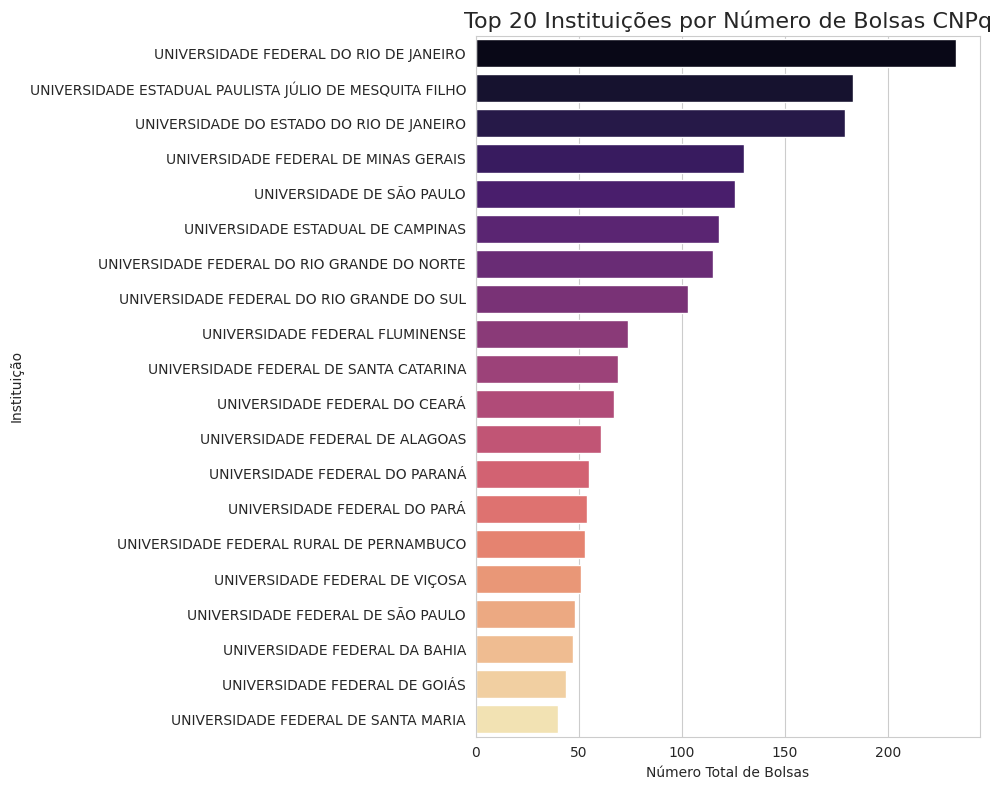


Gerando: Gráfico das 15 Áreas do Conhecimento com Mais Bolsas


/tmp/ipython-input-24-2414566881.py:122: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




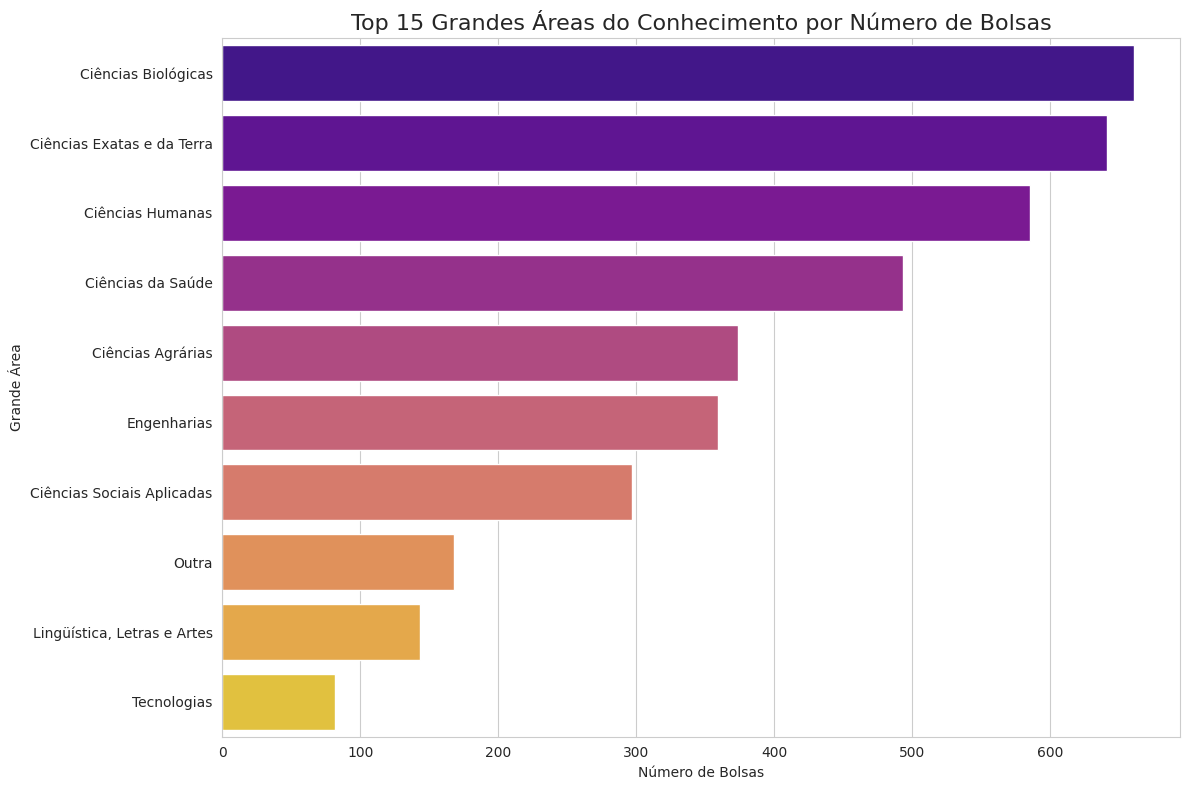


Gerando: Mapa de Distribuição de Bolsas por Estado



Gerando: Boxplot de Comparação Pública vs. Privada e Teste T


/tmp/ipython-input-24-2414566881.py:138: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




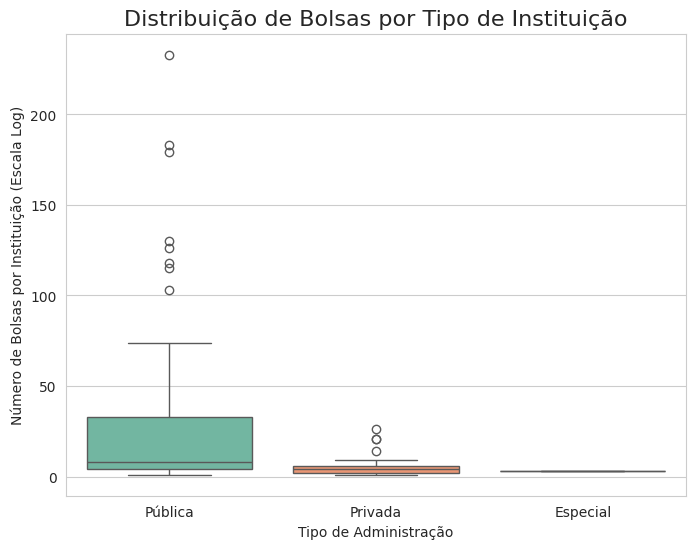

Resultado do Teste T: Estatística t = 5.11, p-valor = 0.0000 -> A diferença é estatisticamente significativa.

Gerando: Gráfico de Dispersão de Nº de Cursos vs. Bolsas e Teste de Correlação


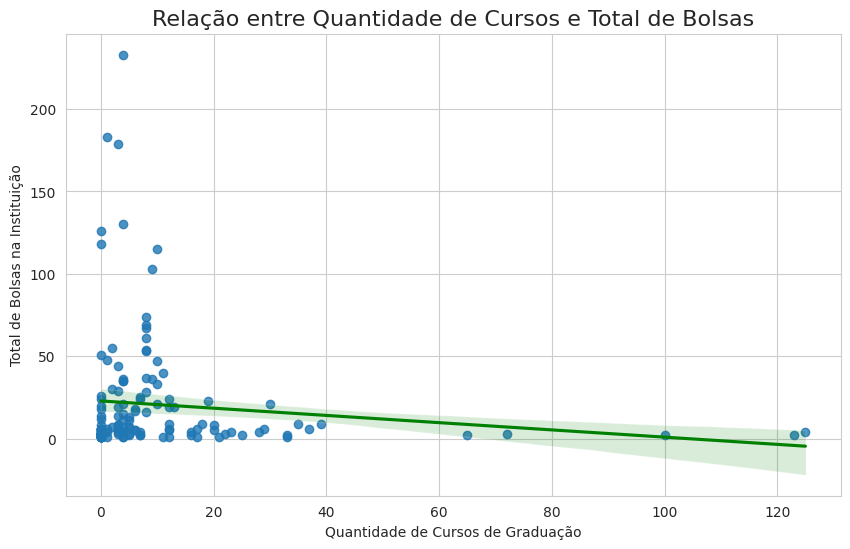

Correlação Cursos vs Bolsas (r = -0.1166, p = 0.1671) -> A correlação é não significativa.


--- ANÁLISE COMPLETA CONCLUÍDA ---


In [24]:
# ==============================================================================
# DESAFIO DE ENGENHARIA DE DADOS
# ==============================================================================

print("--- INICIANDO SETUP E DEFINIÇÃO DE FUNÇÕES ---")

import os
import pandas as pd
import unicodedata
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
from IPython.display import display, Markdown

# Configurações
pd.options.display.float_format = '{:.2f}'.format
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

def normalizar_nome_coluna(nome):
    "Normaliza o nome de uma coluna: minúsculas, sem acentos, espaços/caracteres especiais -> underscore."
    nome_normalizado = unicodedata.normalize('NFKD', str(nome)).encode('ASCII', 'ignore').decode('ASCII')
    nome_normalizado = nome_normalizado.lower()
    nome_normalizado = re.sub(r'\W+', '_', nome_normalizado)
    nome_normalizado = nome_normalizado.strip('_')
    return nome_normalizado

def criar_dataframe_unificado(df_ies, df_cursos, df_cnpq):
    "Cria um DataFrame analítico unificado combinando dados de IES, Cursos e CNPq."
    print("\n--- Unificando e Processando Dados ---")

    # Garante que as colunas-chave sejam numéricas para o merge
    df_ies['co_ies'] = pd.to_numeric(df_ies['co_ies'], errors='coerce')
    df_cursos['co_ies'] = pd.to_numeric(df_cursos['co_ies'], errors='coerce')

    # Processa Cursos para obter contagem por IES
    stats_cursos = df_cursos.dropna(subset=['co_ies']).groupby('co_ies').size().reset_index(name='qtd_cursos_graduacao')

    # Processa IES
    map_cat_admin = {1: 'Pública', 2: 'Pública', 3: 'Pública', 4: 'Privada', 5: 'Privada', 7: 'Especial'}
    df_ies['tipo_admin'] = pd.to_numeric(df_ies['tp_categoria_administrativa'], errors='coerce').map(map_cat_admin).fillna('Outra')

    # Junta IES e Cursos
    df_inep_completo = pd.merge(df_ies, stats_cursos, on='co_ies', how='left').fillna(0)

    # Processa Bolsistas
    coluna_ies_cnpq = 'instituicao_destino'
    if coluna_ies_cnpq not in df_cnpq.columns:
        raise KeyError(f"A coluna '{coluna_ies_cnpq}' não foi encontrada no arquivo do CNPq. Colunas disponíveis: {df_cnpq.columns.tolist()}")
    df_bolsistas_agg = df_cnpq.groupby(coluna_ies_cnpq).size().reset_index(name='total_bolsas')

    # Normaliza nomes das instituições para o merge final
    def normalizar_valores(texto):
        return unicodedata.normalize('NFKD', str(texto)).encode('ASCII', 'ignore').decode('ASCII').upper().strip()

    df_inep_completo['nome_normalizado'] = df_inep_completo['no_ies'].apply(normalizar_valores)
    df_bolsistas_agg['nome_normalizado'] = df_bolsistas_agg[coluna_ies_cnpq].apply(normalizar_valores)

    df_analise = pd.merge(df_inep_completo, df_bolsistas_agg, on='nome_normalizado', how='inner')

    print("DataFrame unificado criado com sucesso!")
    return df_analise, df_cnpq

print("--- FUNÇÕES DEFINIDAS ---")

# --------------------------------------------------------------------------
# ORQUESTRAÇÃO PRINCIPAL
# --------------------------------------------------------------------------
print("\n--- INICIANDO ORQUESTRAÇÃO PRINCIPAL ---")

try:
    # --- ETAPA DE CARREGAMENTO ---
    base_dir = '/content/Inep_extraido'

    ies_path = os.path.join(base_dir, 'MICRODADOS_ED_SUP_IES_2023.CSV')
    cursos_path = os.path.join(base_dir, 'MICRODADOS_CADASTRO_CURSOS_2023.CSV')
    cnpq_path = os.path.join(base_dir, 'Relatorio_de_dados_abertos_CNPq (1º SEM 2023)(snICJ).csv')

    print("Verificando se todos os arquivos de dados existem...")
    for path in [ies_path, cursos_path, cnpq_path]:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Arquivo não encontrado: {path}. Verifique o nome e se o upload para a pasta '{base_dir}' foi concluído.")
    print("Todos os arquivos foram encontrados com sucesso!")

    # Carregamento e Normalização dos Nomes das Colunas
    print("Carregando e normalizando arquivos...")
    df_ies_raw = pd.read_csv(ies_path, sep=';', encoding='latin1', low_memory=False)
    df_ies_raw.columns = [normalizar_nome_coluna(col) for col in df_ies_raw.columns]

    df_cursos_raw = pd.read_csv(cursos_path, sep=';', encoding='latin1', low_memory=False)
    df_cursos_raw.columns = [normalizar_nome_coluna(col) for col in df_cursos_raw.columns]

    df_bolsistas_raw = pd.read_csv(cnpq_path, sep=';', encoding='utf-8-sig', on_bad_lines='warn')
    df_bolsistas_raw.columns = [normalizar_nome_coluna(col) for col in df_bolsistas_raw.columns]
    print("DataFrames brutos carregados e colunas normalizadas.")

    # --- ETAPA DE PROCESSAMENTO ---
    df_analise, df_bolsistas_proc = criar_dataframe_unificado(df_ies_raw, df_cursos_raw, df_bolsistas_raw)
    print("\n--- AMOSTRA DO DATAFRAME DE ANÁLISE FINAL ---")
    display(df_analise.head())

    # --- ETAPA DE ANÁLISE E VISUALIZAÇÃO ---
    print("\n--- INICIANDO ANÁLISES E VISUALIZAÇÕES ---")

    # Análise: Top 20 Instituições com mais bolsas
    print("\nGerando: Gráfico das 20 Instituições com Mais Bolsas")
    plt.figure(figsize=(10, 8))
    dist_ies = df_analise.groupby('no_ies')['total_bolsas'].sum().nlargest(20)
    sns.barplot(x=dist_ies.values, y=dist_ies.index, palette='magma')
    plt.title('Top 20 Instituições por Número de Bolsas CNPq', fontsize=16)
    plt.xlabel('Número Total de Bolsas'); plt.ylabel('Instituição'); plt.tight_layout(); plt.show()

    # Análise: Áreas do conhecimento
    print("\nGerando: Gráfico das 15 Áreas do Conhecimento com Mais Bolsas")
    plt.figure(figsize=(12, 8))
    area_dist = df_bolsistas_proc['grande_area'].value_counts().head(15)
    sns.barplot(x=area_dist.values, y=area_dist.index, palette='plasma')
    plt.title('Top 15 Grandes Áreas do Conhecimento por Número de Bolsas', fontsize=16)
    plt.xlabel('Número de Bolsas'); plt.ylabel('Grande Área'); plt.tight_layout(); plt.show()

    # Análise: Mapa Geográfico
    print("\nGerando: Mapa de Distribuição de Bolsas por Estado")
    dist_uf = df_analise.groupby('sg_uf_ies')['total_bolsas'].sum().reset_index()
    fig_map = px.choropleth(dist_uf, geojson="https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson",
                        locations='sg_uf_ies', featureidkey="properties.sigla", color='total_bolsas',
                        color_continuous_scale="Blues", scope="south america",
                        title='Distribuição Geográfica de Bolsas por Estado')
    fig_map.show()

    # Análise: Comparação Pública vs. Privada com Teste T
    print("\nGerando: Boxplot de Comparação Pública vs. Privada e Teste T")
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_analise, x='tipo_admin', y='total_bolsas', palette='Set2')
    plt.title('Distribuição de Bolsas por Tipo de Instituição', fontsize=16)
    if not df_analise[df_analise['total_bolsas'] <= 0].empty: plt.yscale('log')
    plt.ylabel('Número de Bolsas por Instituição (Escala Log)'); plt.xlabel('Tipo de Administração'); plt.show()

    publica = df_analise[df_analise['tipo_admin'] == 'Pública']['total_bolsas']
    privada = df_analise[df_analise['tipo_admin'] == 'Privada']['total_bolsas']
    if not publica.empty and not privada.empty:
        t_stat, p_value = stats.ttest_ind(publica, privada, equal_var=False, nan_policy='omit')
        print(f"Resultado do Teste T: Estatística t = {t_stat:.2f}, p-valor = {p_value:.4f} -> A diferença é {'estatisticamente significativa.' if p_value < 0.05 else 'não é estatisticamente significativa.'}")

    # Análise Adaptada: Correlação entre Nº de CURSOS e Bolsas
    print("\nGerando: Gráfico de Dispersão de Nº de Cursos vs. Bolsas e Teste de Correlação")
    plt.figure(figsize=(10, 6))
    sns.regplot(data=df_analise, x='qtd_cursos_graduacao', y='total_bolsas', line_kws={"color": "green"})
    plt.title('Relação entre Quantidade de Cursos e Total de Bolsas', fontsize=16)
    plt.xlabel('Quantidade de Cursos de Graduação'); plt.ylabel('Total de Bolsas na Instituição'); plt.show()

    if len(df_analise['qtd_cursos_graduacao']) > 1:
        corr_cur, p_cur = stats.pearsonr(df_analise['qtd_cursos_graduacao'].fillna(0), df_analise['total_bolsas'].fillna(0))
        print(f"Correlação Cursos vs Bolsas (r = {corr_cur:.4f}, p = {p_cur:.4g}) -> A correlação é {'significativa.' if p_cur < 0.05 else 'não significativa.'}")

    print("\n\n--- ANÁLISE COMPLETA CONCLUÍDA ---")



except FileNotFoundError as e:
    print(f"\\nERRO: {e}")
    print("Verifique se você criou a pasta '/content/Inep_extraido' e fez o upload de todos os 3 arquivos CSV para dentro dela.")
except KeyError as e:
    print(f"\\nERRO: {e}")
    print("Uma coluna esperada não foi encontrada. Verifique se os nomes das colunas nos arquivos CSV correspondem ao esperado pelo script.")
except Exception as e:
    print(f"\\nOcorreu um erro inesperado: {e}")

\n--- INICIANDO MODELAGEM PREDITIVA (REGRESSÃO) ---
\nTreinando o modelo RandomForestRegressor...
Treinamento concluído.
\n--- Avaliação do Modelo ---
R-quadrado (R²): -0.1519 (Explica -15.2% da variância no total de bolsas)
Raiz do Erro Quadrático Médio (RMSE): 41.21 bolsas
\n--- Fatores Preditivos Mais Importantes ---


,0
qtd_cursos_graduacao,0.83
tipo_admin_numeric,0.17


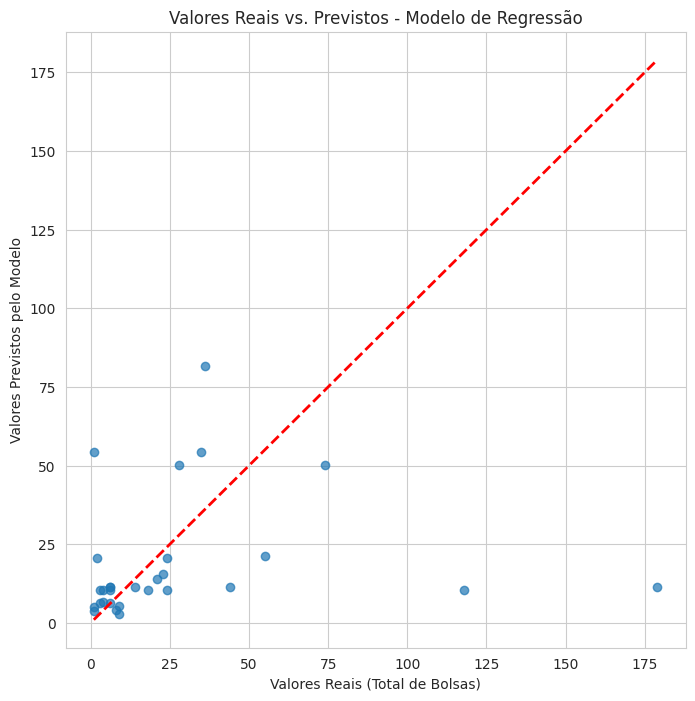

In [32]:
# --- TÓPICO OPCIONAL (a): MODELO DE REGRESSÃO ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display
import numpy as np # Import numpy for sqrt

print("\\n--- INICIANDO MODELAGEM PREDITIVA (REGRESSÃO) ---")

# 1. Preparação dos Dados (Features e Target)
# Convertendo 'tipo_admin' para numérico (0 para Privada, 1 para Pública)
df_model = df_analise.copy()
df_model['tipo_admin_numeric'] = (df_model['tipo_admin'] == 'Pública').astype(int)

# Selecionando as características (X) e o alvo (y)
# A coluna 'qtd_doutores' foi removida pois não está presente no dataframe atual
# Conforme notado na seção de limitações da análise.
features = ['qtd_cursos_graduacao', 'tipo_admin_numeric']
target = 'total_bolsas'

X = df_model[features]
y = df_model[target]

# 2. Divisão em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Treinamento do Modelo
print("\\nTreinando o modelo RandomForestRegressor...")
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)
print("Treinamento concluído.")

# 4. Avaliação do Modelo
y_pred = rf_regressor.predict(X_test)
r2 = r2_score(y_test, y_pred)
# Calculate MSE first
mse = mean_squared_error(y_test, y_pred)
# Manually calculate RMSE by taking the square root of MSE
rmse = np.sqrt(mse)

print(f"\\n--- Avaliação do Modelo ---")
print(f"R-quadrado (R²): {r2:.4f} (Explica {r2:.1%} da variância no total de bolsas)")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f} bolsas")

# 5. Importância das Características
print("\\n--- Fatores Preditivos Mais Importantes ---")
feature_importances = pd.Series(rf_regressor.feature_importances_, index=features).sort_values(ascending=False)
display(feature_importances)

# 6. Visualização da Relação entre Valores Reais e Previstos
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2)
plt.xlabel('Valores Reais (Total de Bolsas)')
plt.ylabel('Valores Previstos pelo Modelo')
plt.title('Valores Reais vs. Previstos - Modelo de Regressão')
plt.show()

\n--- INICIANDO MODELAGEM PREDITIVA (CLASSIFICAÇÃO) ---
\nTreinando o modelo RandomForestClassifier...
Treinamento concluído.
\n--- Avaliação do Modelo de Classificação ---
Acurácia: 0.55 (O modelo acerta 55.2% das classificações)
\nRelatório de Classificação:
              precision    recall  f1-score   support

        Alta       0.57      0.40      0.47        10
       Baixa       0.53      0.67      0.59        12
       Média       0.57      0.57      0.57         7

    accuracy                           0.55        29
   macro avg       0.56      0.55      0.54        29
weighted avg       0.56      0.55      0.55        29

\n--- Fatores Mais Importantes para a Classificação ---


,0
qtd_cursos_graduacao,0.81
tipo_admin_numeric,0.19


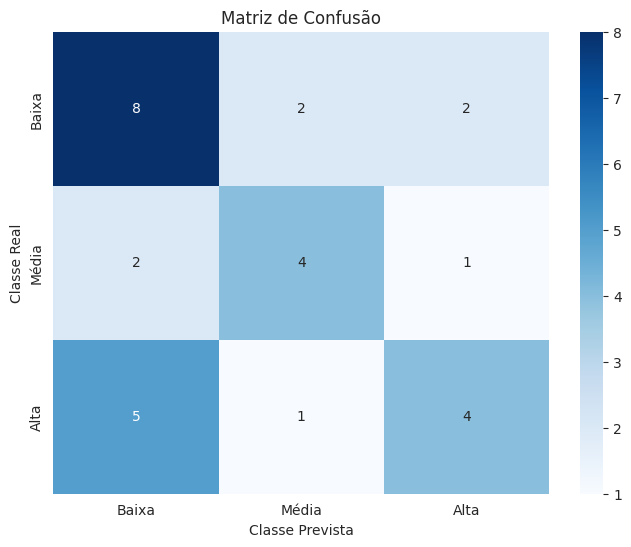

In [33]:
# --- TÓPICO OPCIONAL (b): MODELO DE CLASSIFICAÇÃO ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd # Import pandas as it's used implicitly
from sklearn.metrics import confusion_matrix

print("\\n--- INICIANDO MODELAGEM PREDITIVA (CLASSIFICAÇÃO) ---")

# 1. Preparação dos Dados (Criação da Categoria-Alvo)
if 'df_model' not in locals():
    print("df_model not found. Please run the previous cell first.")


if 'total_bolsas' not in df_model.columns:
    print("Coluna 'total_bolsas' não encontrada em df_model. Verifique a criação do dataframe.")
elif df_model['total_bolsas'].nunique() < 3:
     print("A coluna 'total_bolsas' tem menos de 3 valores únicos, não é possível criar 3 categorias.")
     print(f"Valores únicos: {df_model['total_bolsas'].unique()}")
else:
    try:
        df_model['produtividade_cat'] = pd.qcut(df_model['total_bolsas'], q=3, labels=['Baixa', 'Média', 'Alta'], duplicates='drop')

        # Selecionando as características (X) e o novo alvo (y)
        # 'qtd_doutores' removida pois não está presente no df_model
        features = ['qtd_cursos_graduacao', 'tipo_admin_numeric']
        target_cat = 'produtividade_cat'

        if not all(item in df_model.columns for item in features):
             missing_features = [item for item in features if item not in df_model.columns]
             print(f"Erro: As seguintes features não foram encontradas em df_model: {missing_features}")
        elif target_cat not in df_model.columns:
             print(f"Erro: A coluna alvo '{target_cat}' não foi encontrada em df_model.")
        else:
            X_cat = df_model[features]
            y_cat = df_model[target_cat]

            if y_cat.nunique() < 2 or y_cat.value_counts().min() < 2:
                print(f"Não há classes suficientes ou amostras por classe (<2) para stratify. Classes: {y_cat.value_counts().to_dict()}")
                X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42)
            else:
                 # 2. Divisão em Treino e Teste
                X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42, stratify=y_cat)


            # 3. Treinamento do Modelo
            print("\\nTreinando o modelo RandomForestClassifier...")
            rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
            rf_classifier.fit(X_train_cat, y_train_cat)
            print("Treinamento concluído.")

            # 4. Avaliação do Modelo
            y_pred_cat = rf_classifier.predict(X_test_cat)
            accuracy = accuracy_score(y_test_cat, y_pred_cat)

            print(f"\\n--- Avaliação do Modelo de Classificação ---")
            print(f"Acurácia: {accuracy:.2f} (O modelo acerta {accuracy:.1%} das classificações)")
            print("\\nRelatório de Classificação:")
            print(classification_report(y_test_cat, y_pred_cat))

            # 5. Fatores Mais Importantes para a Classificação
            print("\\n--- Fatores Mais Importantes para a Classificação ---")
            feature_importances_cat = pd.Series(rf_classifier.feature_importances_, index=features).sort_values(ascending=False)
            display(feature_importances_cat)

    except ValueError as e:
        print(f"Erro ao criar categorias de produtividade com qcut: {e}")
        print("Isso pode ocorrer se houver pouca variação nos dados de 'total_bolsas'.")




cm = confusion_matrix(y_test_cat, y_pred_cat, labels=['Baixa', 'Média', 'Alta'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Baixa', 'Média', 'Alta'], yticklabels=['Baixa', 'Média', 'Alta'])
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

\n--- INICIANDO ANÁLISE DE CLUSTERS ---


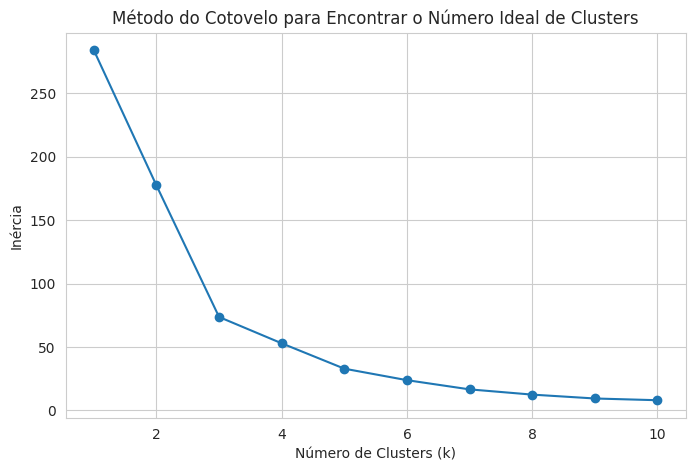

\nInstituições agrupadas em 3 clusters.


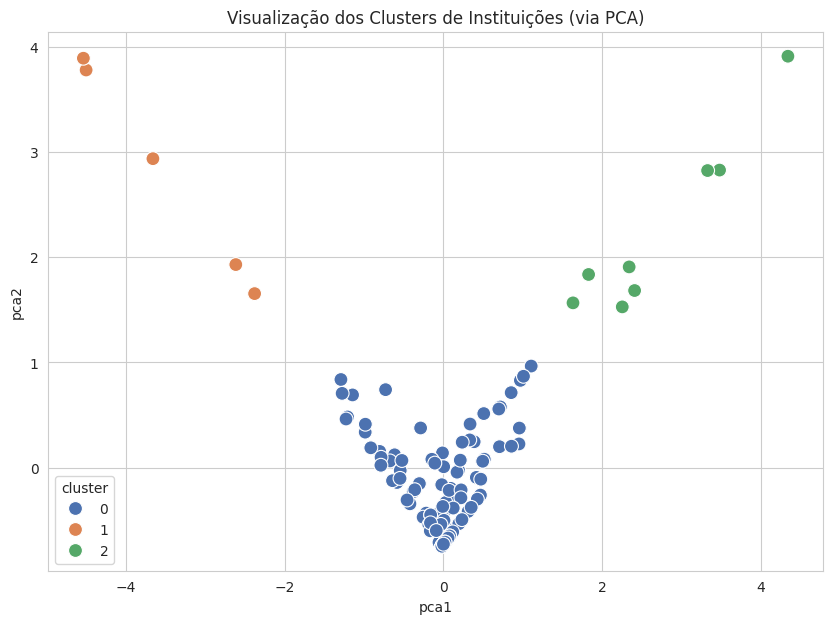

\n--- Perfil Médio de Cada Cluster ---


,qtd_cursos_graduacao,total_bolsas
cluster,,
2,3.88,148.38
0,6.91,13.45
1,97.00,2.60


In [31]:
# --- TÓPICO OPCIONAL (c): CLUSTERING DE INSTITUIÇÕES ---
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported

print("\\n--- INICIANDO ANÁLISE DE CLUSTERS ---")

# 1. Seleção e Padronização das Variáveis
# 'qtd_doutores' removida pois não está presente no df_analise
cluster_features = ['qtd_cursos_graduacao', 'total_bolsas']

# Check if the required features exist in df_analise
if not all(feature in df_analise.columns for feature in cluster_features):
    missing = [feature for feature in cluster_features if feature not in df_analise.columns]
    print(f"Erro: As seguintes colunas necessárias para o clustering não foram encontradas: {missing}")
else:
    X_cluster = df_analise[cluster_features].fillna(0)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)

    # 2. Encontrar o Número Ideal de Clusters (Método do Cotovelo)
    inertia = []
    if X_scaled.shape[0] > 1:
        for k in range(1, min(11, X_scaled.shape[0])):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X_scaled)
            inertia.append(kmeans.inertia_)

        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(inertia) + 1), inertia, marker='o')
        plt.title('Método do Cotovelo para Encontrar o Número Ideal de Clusters')
        plt.xlabel('Número de Clusters (k)')
        plt.ylabel('Inércia')
        plt.show()

        # 3. Aplicar o K-Means com o k escolhido (ex: k=3 ou 4, baseado no gráfico)
        k_ideal = 3
        if k_ideal > X_scaled.shape[0]:
            print(f"Erro: O número ideal de clusters ({k_ideal}) é maior que o número de amostras ({X_scaled.shape[0]}). Reduzindo k_ideal.")
            k_ideal = X_scaled.shape[0] if X_scaled.shape[0] > 0 else 1 # Handle case with 0 samples

        if k_ideal > 1:
            kmeans = KMeans(n_clusters=k_ideal, random_state=42, n_init=10)
            df_analise['cluster'] = kmeans.fit_predict(X_scaled)
            print(f"\\nInstituições agrupadas em {k_ideal} clusters.")

            # 4. Análise e Visualização dos Clusters com PCA
            if X_scaled.shape[0] > 1 and X_scaled.shape[1] >= 2:
                 pca = PCA(n_components=2)
                 X_pca = pca.fit_transform(X_scaled)
                 df_analise['pca1'] = X_pca[:, 0]
                 df_analise['pca2'] = X_pca[:, 1]

                 plt.figure(figsize=(10, 7))
                 sns.scatterplot(data=df_analise, x='pca1', y='pca2', hue='cluster', palette='deep', s=100)
                 plt.title('Visualização dos Clusters de Instituições (via PCA)')
                 plt.show()
            elif X_scaled.shape[1] < 2:
                 print("Não há features suficientes (precisa de pelo menos 2) para visualização com PCA 2D.")
            else:
                print("Não há amostras suficientes para visualização com PCA.")


            # 5. Descrever os perfis dos clusters
            print("\\n--- Perfil Médio de Cada Cluster ---")
            if 'cluster' in df_analise.columns:
                 cluster_profile = df_analise.groupby('cluster')[cluster_features].mean().sort_values(by='total_bolsas', ascending=False)
                 display(cluster_profile)
            else:
                 print("O clustering não foi executado (sem amostras suficientes ou k_ideal <= 1). Não é possível mostrar o perfil dos clusters.")
        else:
            print(f"Não é possível executar o clustering com {k_ideal} clusters (k_ideal deve ser > 1). Verifique o método do cotovelo ou o número de amostras.")

    else:
        print("Não há amostras suficientes para realizar o clustering.")
